# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
nans = azdias.isnull().mean().sort_values(ascending = False)

nans

KK_KUNDENTYP             0.655967
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
KBA05_ANTG4              0.149597
KBA05_BAUMAX             0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
REGIOTYP                 0.135989
KKK                      0.135989
PLZ8_ANTG3               0.130736
PLZ8_ANTG1               0.130736
PLZ8_GBZ                 0.130736
PLZ8_ANTG2               0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
W_KEIT_KIND_HH           0.120735
KBA13_ANZAHL_PKW         0.118714
CAMEO_INTL_2015          0.111060
CAMEO_DEU_2015           0.111060
CAMEO_DEUG_2015          0.111060
ORTSGR_KLS9              0.109082
ARBEIT                   0.109082
RELAT_AB                 0.109082
ANZ_HH_TITEL             0.108848
BALLRAUM                 0.105182
EWDICHTE                 0.105182
INNENSTADT               0.105182
GEBAEUDETYP_RA

In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [9]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [10]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,FINANZ_ANLEGER,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

azdias_null_values = azdias.isnull().sum()

#print(azdias_null_values)

print("Total missing values in Azdias dataset: ", azdias_null_values.sum())


Total missing values in Azdias dataset:  4896838


In [12]:
for col in range(len(feat_info)):
    invalid = feat_info.iloc[col]['missing_or_unknown']
    invalid = invalid.strip('[]')
    invalid = invalid.split(sep=',')
    invalid = [int(item) if (item!='X' and item!='XX' and item!='') else item for item in invalid]
    if invalid != ['']:
        azdias = azdias.replace({feat_info.iloc[col]['attribute']: invalid}, np.nan)
    

In [13]:
print('Total missing values after converting invalid items to NaNs:  {}'.format(azdias.isnull().sum().sum()))


Total missing values after converting invalid items to NaNs:  8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_values_columns = azdias.isnull().sum()


missing_values_columns.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [15]:
missing_values_columns.sort_values(ascending = False)
missing_values_columns.shape

(85,)

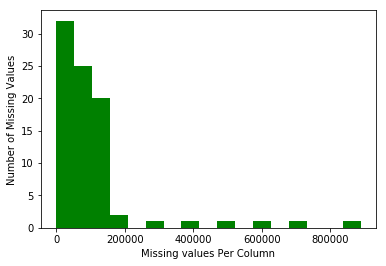

In [16]:
# Investigate patterns in the amount of missing data in each column.
#missing_col.hist(facecolor='B',grid=True);

plt.hist(missing_values_columns,facecolor='g', bins = 'auto')
plt.xlabel('Missing values Per Column')
plt.ylabel('Number of Missing Values')
plt.show()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

outliers = missing_values_columns[missing_values_columns>200000]
azdias.drop(outliers.index, axis=1, inplace=True)
azdias.shape

(891221, 79)

In [18]:
missing_values_columns

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [19]:
outliers

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

#### Discussion 1.1.2: Assess Missing Data in Each Column

After handling all the invalid values in the azdias dataset and replacing them with NaNs, We can observe that a lot of the columns have missing data but, we cannot ignore or drop everything. So, I focused on those columns that have the maximum number of missing values among all. 
Therefore, I decide to drop [AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX ] these six columns from the Azdias dataset becasue they have more that 20% of their data missing and kept all the others for further processing.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?

missing_row = azdias.isnull().sum(axis=1)
missing_row

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

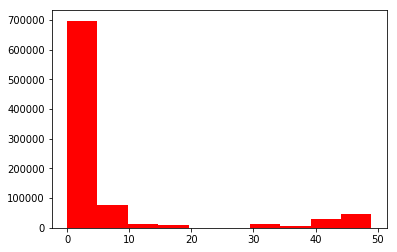

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


plt.hist(missing_row, facecolor='r')
plt.show()

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

subset_less_than_20_percent_missing = azdias[azdias.isnull().sum(axis =1) <= 10]
subset_more_than_20_percent_missing = azdias[azdias.isnull().sum(axis = 1) >10]

In [23]:
subset_less_than_20_percent_missing.shape

(780153, 79)

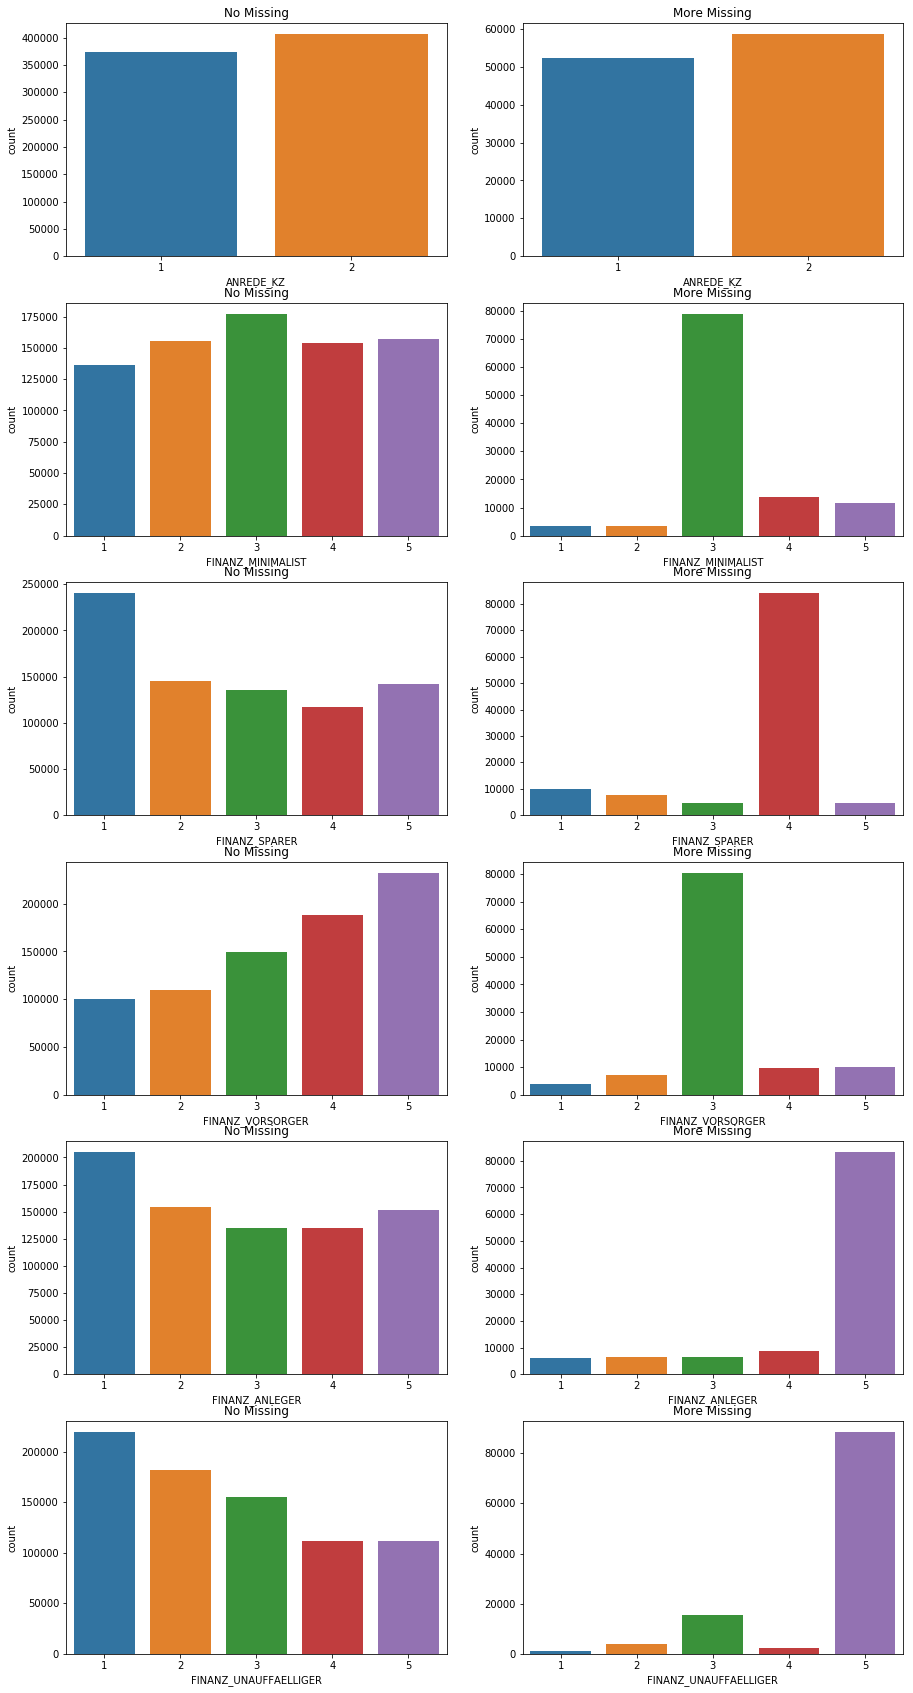

In [24]:
total_missing = missing_values_columns[missing_values_columns==0].index.tolist()
num_columns = total_missing[:6]

plot, axis = plt.subplots(nrows = len(num_columns), ncols= 2, figsize=(15,30))
plot.subplots_adjust(hspace = 0.2, wspace = 0.2)

for i in range(len(num_columns)):
    sns.countplot(subset_less_than_20_percent_missing[num_columns[i]], ax=axis[i,0])
    axis[i,0].set_title('No Missing')
    sns.countplot(subset_more_than_20_percent_missing[num_columns[i]], ax=axis[i,1])
    axis[i,1].set_title('More Missing')

#### Discussion 1.1.3: Assess Missing Data in Each Row

After droping the outlier columns, we can see that 79 columns out of 85 have less than 20% data missing. 
Observing the overall missing values in all the remaining columns, we can see that a threshold of 10% seems an appropriate cutoff point for bifurcating our dataset. 
Looking at the two subsets, it can be seen that there are quite a few similarities between the datasets with few missing qualities (left) and the one with more than 10% missing values (right). So, it is quite safe to ignore the subet with more missing values and proceed with the subset will less missing values for further analyses.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [25]:
# How many features are there of each data type?

feat_info.groupby('type').count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values

categorical = [val for val in categorical if val in azdias.columns] 

binary = [var for var in categorical if azdias[var].nunique()==2]

multilevel = [var for var in categorical if azdias[var].nunique()>2]

azdias[categorical].nunique()



ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [27]:
print("Total categorical variables: ",azdias[categorical].nunique().sum())

Total categorical variables:  138


In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

multilevel.remove("CAMEO_DEU_2015")

subset_less_than_20_percent_missing.drop("CAMEO_DEU_2015", axis = 1, inplace = True)

In [30]:
for nan in binary:
    if subset_less_than_20_percent_missing[nan].dtype == object:
        print(subset_less_than_20_percent_missing[nan].value_counts())

W    614719
O    165434
Name: OST_WEST_KZ, dtype: int64


In [31]:
subset_less_than_20_percent_missing.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True) # converting binary non numberic value

In [32]:
subset_less_than_20_percent_missing.shape

(780153, 78)

In [33]:
print(multilevel)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [34]:
#for var in multilevel:
#    mul = subset_less_than_20_percent_missing[var][subset_less_than_20_percent_missing[var].notnull()]
#    dummy = pd.get_dummies(mul, prefix=var)
#    subset_less_than_20_percent_missing = subset_less_than_20_percent_missing.join(dummy)
#    subset_less_than_20_percent_missing.drop([var], axis=1, inplace=True)

In [35]:
subset_less_than_20_percent_missing.drop(multilevel, axis = 1, inplace = True)

In [36]:
azdias[categorical].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [37]:
subset_less_than_20_percent_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Data columns (total 66 columns):
ALTERSKATEGORIE_GROB     777528 non-null float64
ANREDE_KZ                780153 non-null int64
FINANZ_MINIMALIST        780153 non-null int64
FINANZ_SPARER            780153 non-null int64
FINANZ_VORSORGER         780153 non-null int64
FINANZ_ANLEGER           780153 non-null int64
FINANZ_UNAUFFAELLIGER    780153 non-null int64
FINANZ_HAUSBAUER         780153 non-null int64
GREEN_AVANTGARDE         780153 non-null int64
HEALTH_TYP               745629 non-null float64
LP_LEBENSPHASE_FEIN      733579 non-null float64
LP_LEBENSPHASE_GROB      736259 non-null float64
PRAEGENDE_JUGENDJAHRE    753679 non-null float64
RETOURTYP_BK_S           776319 non-null float64
SEMIO_SOZ                780153 non-null int64
SEMIO_FAM                780153 non-null int64
SEMIO_REL                780153 non-null int64
SEMIO_MAT                780153 non-null int64
SEMIO_VERT               780153

#### Discussion 1.2.1: Re-Encode Categorical Features

After separting the data into two subsets (one with less than 10% missing values and other one with more than 10% missing), I assessed the categorical features of "less missing dataset" and extracting them out into binary and multilevel features. 
I verified if all the variables in the binary features were numeric data type or not. I found out the "OST_WEST_KZ" had its data encoded as string, so, I re-encoded its values with one-hot encoding.
To make the further investigation smooth, I decided to drop all the multilevel variables and proceeded with further analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values

mixed = [var for var in mixed if var in subset_less_than_20_percent_missing.columns]


In [39]:
subset_less_than_20_percent_missing.PRAEGENDE_JUGENDJAHRE.sample(10)

680807    10.0
642455     1.0
135589    11.0
38610     10.0
362435     8.0
211224    14.0
76375     14.0
655248    14.0
127560    12.0
254504     5.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [40]:
subset_less_than_20_percent_missing.PRAEGENDE_JUGENDJAHRE.nunique()

15

In [41]:
subset_less_than_20_percent_missing.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    178410
8.0     138678
10.0     83881
5.0      83645
3.0      53098
15.0     41029
11.0     34642
9.0      33197
6.0      25517
12.0     24034
4.0      20343
1.0      20242
2.0       7438
13.0      5561
7.0       3964
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [42]:
nan = subset_less_than_20_percent_missing.PRAEGENDE_JUGENDJAHRE.isnull().sum()
percent = subset_less_than_20_percent_missing.PRAEGENDE_JUGENDJAHRE.isnull().mean() * 100

print("Missing Values in PRAEGENDE_JUGENDJAHRE: ", nan)
print("Percent Missing: ",percent)

Missing Values in PRAEGENDE_JUGENDJAHRE:  26474
Percent Missing:  3.3934369284


In [43]:
# Movement
# mainstream = 1, 3, 5, 8, 10, 12, 14
# avantgarde = 2, 4, 6, 7, 9, 11, 13, 15


# generation
# 40s = 1
# 50s = 2
# 60s = 3
# 70s = 4
# 80s = 5
# 90s = 6

generation = {1: 1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

movement = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}

subset_less_than_20_percent_missing['GENERATION'] = subset_less_than_20_percent_missing['PRAEGENDE_JUGENDJAHRE'].map(generation)
subset_less_than_20_percent_missing['MOVEMENT'] = subset_less_than_20_percent_missing['PRAEGENDE_JUGENDJAHRE'].map(movement)

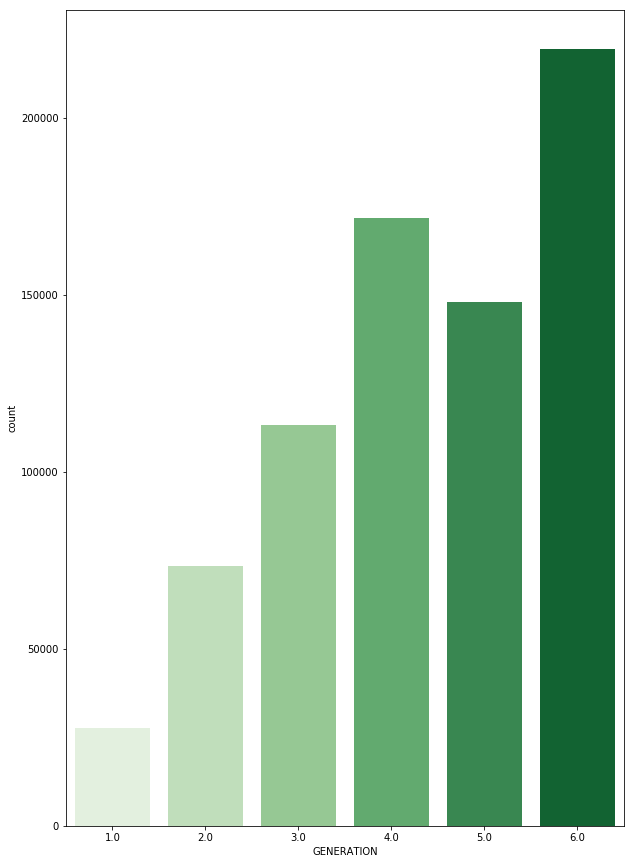

In [44]:
fig, ax1 = plt.subplots(figsize=(10,15))
sns.countplot(data=subset_less_than_20_percent_missing,
              x='GENERATION',
              palette="Greens",
              ax=ax1);

In [45]:
subset_less_than_20_percent_missing['GENERATION'].isnull().sum()  # checking if NANs are still same


26474

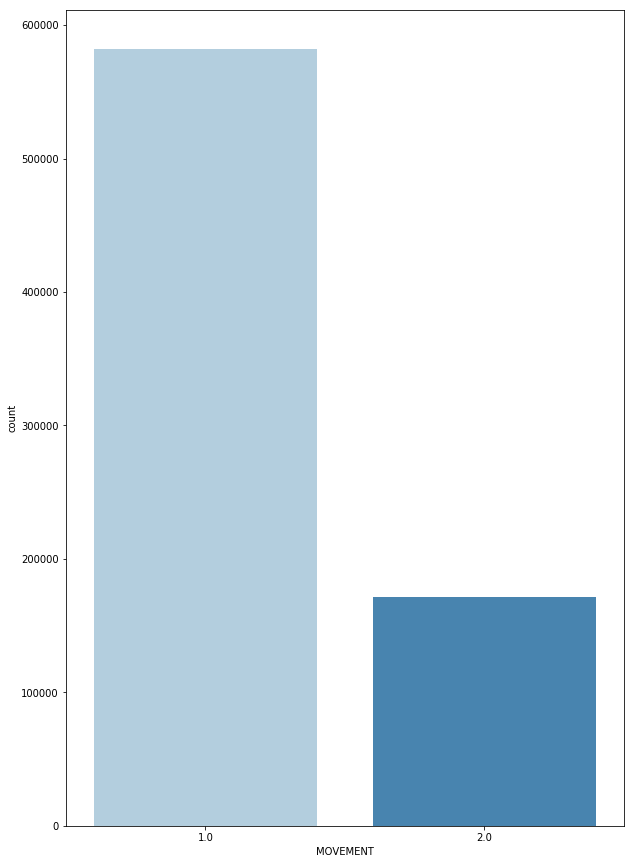

In [46]:
fig, ax1 = plt.subplots(figsize=(10,15))
sns.countplot(data=subset_less_than_20_percent_missing,
              x='MOVEMENT',
              palette="Blues",
              ax=ax1);

In [47]:
subset_less_than_20_percent_missing['MOVEMENT'].isnull().sum()  # checking if NANs are still same

26474

In [48]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
subset_less_than_20_percent_missing.CAMEO_INTL_2015.value_counts()


51    132853
41     91071
24     89200
14     61422
43     55836
54     45004
25     38860
22     32235
45     25771
13     25659
23     24280
55     23609
52     20388
34     18237
31     17853
15     16735
44     14593
12     12890
35     10212
32     10153
33      9636
Name: CAMEO_INTL_2015, dtype: int64

In [49]:
nans = subset_less_than_20_percent_missing.CAMEO_INTL_2015.isnull().sum()

percent = subset_less_than_20_percent_missing.CAMEO_INTL_2015.isnull().mean() *100


print("Missing Values of CAMEO_INTL_2015: ", nans)
print("Percent Missing: ",percent)

Missing Values of CAMEO_INTL_2015:  3656
Percent Missing:  0.468626025921


In [50]:
subset_less_than_20_percent_missing['WEALTH'] = subset_less_than_20_percent_missing['CAMEO_INTL_2015'].str[0]
subset_less_than_20_percent_missing['LIFE_STAGE'] = subset_less_than_20_percent_missing['CAMEO_INTL_2015'].str[1]

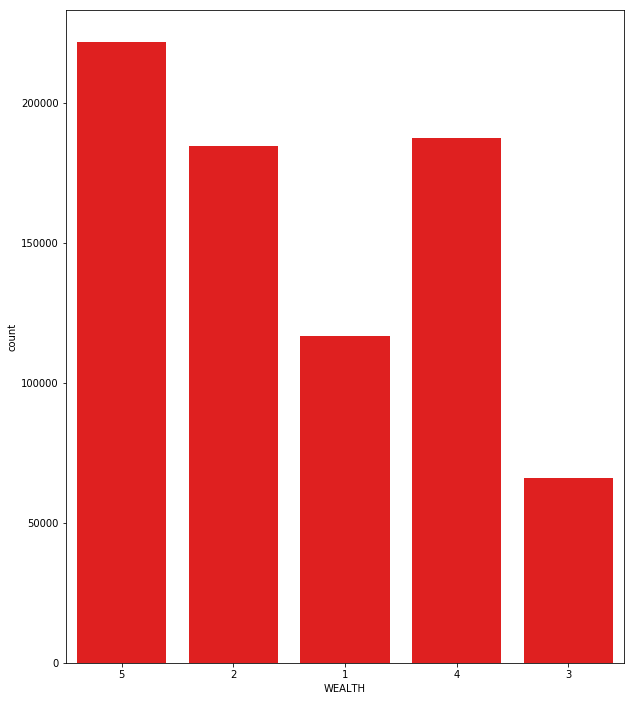

In [51]:
fig, ax1 = plt.subplots(figsize=(10,12))
sns.countplot(data=subset_less_than_20_percent_missing,
              x='WEALTH',
              color = 'red',
              ax=ax1);

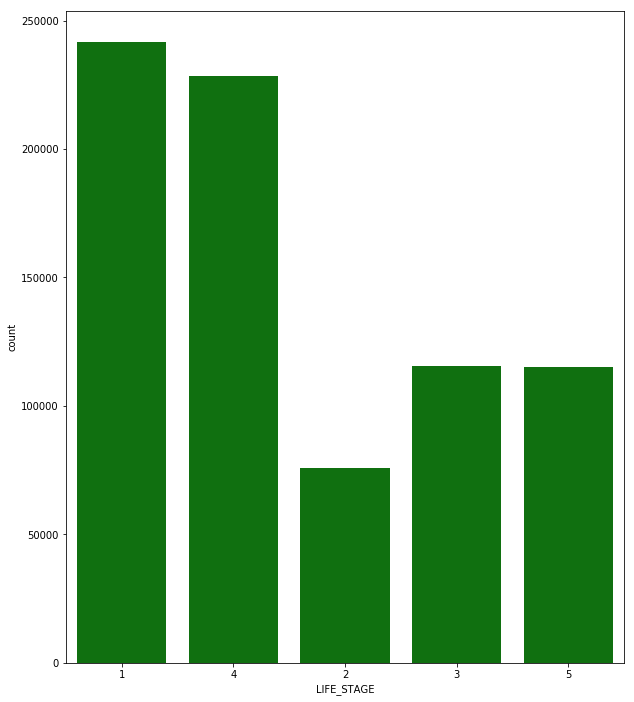

In [52]:
fig, ax1 = plt.subplots(figsize=(10,12))
sns.countplot(data=subset_less_than_20_percent_missing,
              x='LIFE_STAGE',
              color = 'green',
              ax=ax1);

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For the mixed value features, I had to keep "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" columns in my sub-dataset.
On investigation the PRAEGENDE_JUGENDJAHRE column, I found out that-

Level 14 (90s - digital media kids (Mainstream, E+W)) leads with close to 178410 rows followed by level 8 (70s - family orientation (Mainstream, E+W)) with 138678 observations

Levels 7 (60s - opponents to the building of the Wall (Avantgarde, E)), 13 ((80s - Swords into ploughshares (Avantgarde, E)) and 2 (40s - reconstruction years (Avantgarde, E+W)) have the least observations with 3964, 5561 and 7438 rows respectively

Number of missing values in PRAEGENDE_JUGENDJAHRE:  26474
Percent Missing:  3.39%

This feature seems mucg granular and needs to be re-engineered into two separate variables- "Generation and "Movement" for mapping the values of different generations (from 1940s to 1990s) and their inclination towards different types of media (avantagarde or mainstream) respectively.
Finaly after engineering two new variables, it was safe to drop PRAEGENDE_JUGENDJAHRE from the dataset.


Next, on investigation the CAMEO_INTL_2015 column, I found out that it contained data related to different levels of life stage for families ranging from (youth to elderly) and the amount of wealth associated with them. This features seems very important in making decision about customer segmentation later in the project so, it can not be dropped.

Number of missing values in CAMEO_INTL_2015:  3656
Percent Missing:  46.86% 

CAMEO_INTL_2015 has high percentage of values missing which, if left untreated may cause huge variations in clustering. So, I decide to re-engineer two different variables "Life-stage" and "Wealth" to map previous values of original feature and finally drop CAMEO_INTL_2015 as we have already covered all the necessary details in the newly engineered variables.

Finally, engineering all the rest of mixed-level features would have increased complexity in analyses, so I decided to drop them as well.

Reference:

https://jkarakas.github.io/Customer-Demographics-Segmentation-/Customer_Segmentation.html#Engineer-Mixed-Type-Features


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

df = subset_less_than_20_percent_missing.copy(deep = True)

In [54]:
df.drop(mixed, axis=1, inplace=True)


In [55]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2,4
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1,2
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4,3
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5,4


In [56]:
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

In [57]:
df.shape

(780153, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [58]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    
    for col in range(len(feat_info)):
        invalid = feat_info.iloc[col]['missing_or_unknown']
        invalid = invalid.strip('[]')
        invalid = invalid.split(sep=',')
        invalid = [int(item) if (item!='X' and item!='XX' and item!='') else item for item in invalid]
        if invalid != ['']:
            df = df.replace({feat_info.iloc[col]['attribute']: invalid}, np.nan)
        
    for col in df.columns:
        df = df.replace({col: ['XX', 'X']}, np.nan)
    
    # remove selected columns and rows, ...
    
    missing_columns = df.isnull().sum()
    
    outlier_col = missing_columns[missing_columns>200000]
    df.drop(outlier_col.index, axis=1, inplace=True)

    # select, re-encode, and engineer column values.
    
    low_subset = df[df.isnull().sum(axis =1) <= 10]
    
#    df.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)

    low_subset.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
    
    
    features = list(low_subset.columns)
    feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
    
    categories = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    multi_level=[]
    
    for feat in categories:
        if (len(low_subset[feat].unique())>2):
            multi_level.append(feat)
            
    for feat in multi_level:
        low_subset=low_subset.drop(feat, axis =1)
#        df=df.drop(feat, axis=1)

    
    
#    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
#    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    
    low_subset['DECADE'] = low_subset['PRAEGENDE_JUGENDJAHRE']
    low_subset['MOVEMENT'] = low_subset['PRAEGENDE_JUGENDJAHRE']
    
    generation = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
#    df['DECADE'].replace(generation, inplace=True)
#    df['MOVEMENT'].replace(movement, inplace=True)

    low_subset['DECADE'].replace(generation, inplace=True)
    low_subset['MOVEMENT'].replace(movement, inplace=True)
    
#    df['WEALTH'] = df['CAMEO_INTL_2015']
#    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    
    low_subset['WEALTH'] = low_subset['CAMEO_INTL_2015']
    low_subset['LIFE_STAGE'] = low_subset['CAMEO_INTL_2015']
    
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    
    life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    low_subset['WEALTH'].replace(wealth, inplace=True)
    low_subset['LIFE_STAGE'].replace(life_stage, inplace=True)
    
    
#    df['WEALTH'].replace(wealth, inplace=True)
#    df['LIFE_STAGE'].replace(life_stage, inplace=True)
    
    
    mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    for feature in mixed_features:
        low_subset.drop(feature, axis=1, inplace=True)
        
#        df.drop(feature, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return low_subset

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imputer = Imputer()


less_missing_data = pd.DataFrame(imputer.fit_transform(subset_less_than_20_percent_missing),
                                 columns = subset_less_than_20_percent_missing.columns)



In [60]:
less_missing_data.isnull().sum().sum()

0

In [61]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = pd.DataFrame(scaler.fit_transform(less_missing_data), columns = less_missing_data.columns)

In [62]:
scaled_data

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.767099,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.078455,...,-6.507700e-01,1.432164e+00,5.605347e-01,-1.750584e-01,-1.335265e-01,6.792646e-01,1.169476,-0.552603,1.180325,-1.260258
1,0.198771,0.958395,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.078455,...,-6.507700e-01,3.997013e-01,5.605347e-01,-1.750584e-01,-1.335265e-01,-7.958228e-01,1.169476,1.873182,-0.871579,0.760774
2,1.181706,0.958395,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-6.507700e-01,-6.327617e-01,5.605347e-01,-1.180812e+00,-1.004438e+00,-5.827910e-02,-0.225811,-0.552603,-1.555547,-0.586581
3,0.198771,-1.043411,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.078455,...,3.761877e-02,-6.327617e-01,-3.437227e-01,8.306951e-01,3.019294e-01,1.416808e+00,-0.225811,-0.552603,0.496357,0.087097
4,-1.767099,0.958395,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.078455,...,-6.507700e-01,1.432164e+00,1.464792e+00,-1.180812e+00,-1.004438e+00,-5.827910e-02,-1.621097,-0.552603,1.180325,0.760774
5,-0.784164,0.958395,-1.488140,1.539080,-1.771610,1.467273,0.980071,-0.102971,-0.531199,-0.276116,...,-6.507700e-01,1.432164e+00,1.464792e+00,8.306951e-01,3.019294e-01,-5.827910e-02,0.471833,-0.552603,-0.871579,-0.586581
6,-1.767099,-1.043411,-0.036761,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,-1.630686,...,-6.507700e-01,3.997013e-01,5.605347e-01,-1.180812e+00,-1.335265e-01,-7.958228e-01,-0.225811,-0.552603,-1.555547,0.760774
7,0.198771,-1.043411,0.688928,0.866538,-1.045251,0.788502,-0.454983,-0.817895,1.882535,1.078455,...,-6.507700e-01,-6.327617e-01,-3.437227e-01,-1.180812e+00,-5.689823e-01,-5.827910e-02,0.471833,1.873182,-1.555547,0.087097
8,0.198771,0.958395,-0.762450,0.866538,-1.045251,0.109731,1.697599,0.611953,1.882535,-0.276116,...,-6.507700e-01,-6.327617e-01,-3.437227e-01,-1.180812e+00,-1.004438e+00,-1.533367e+00,1.169476,1.873182,-1.555547,1.434452
9,0.198771,0.958395,-0.762450,-0.478545,1.133828,0.109731,-1.172510,1.326876,-0.531199,-0.276116,...,3.761877e-02,-6.327617e-01,-3.437227e-01,8.306951e-01,3.019294e-01,1.416808e+00,-1.621097,-0.552603,1.180325,-1.260258


### Discussion 2.1: Apply Feature Scaling

After cleaning and feature engineering the "less missing dataset" it is important to check if I missed to take care of the preprocessing for all the values. Before, applying StandardScaler to scale our data, it is important to take care of any remaining NAN values in the dataset.

I used the Imputer fuction from sklearn to remove the NaN values from the dataset, if any, before standarding the sub-dataset. 
The scaled data now has all the features measured at the same scale so they contribute equally to further analyses, without creating any biases.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [63]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()

pca_data = pca.fit_transform(scaled_data)


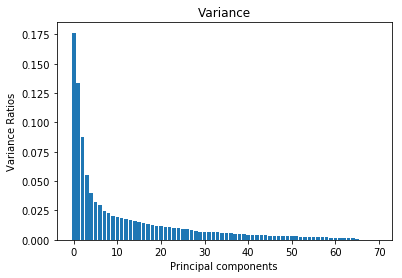

In [64]:
# Investigate the variance accounted for by each principal component.

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance")
plt.xlabel("Principal components")
plt.ylabel("Variance Ratios")
plt.show()


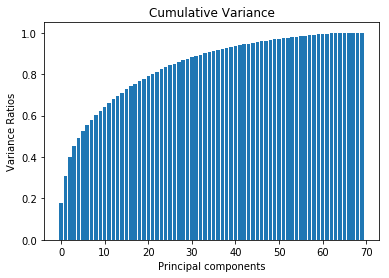

In [65]:
plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Variance")
plt.xlabel("Principal components")
plt.ylabel("Variance Ratios")
plt.show()

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_28 = PCA(n_components=28)
new_pca_data = pca_28.fit_transform(scaled_data)

In [90]:
new_pca_data.shape

(780153, 28)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

In order to reduce dimension of our dataset, it is important to consider the individual varaiance ratios as well as the cumulative variance rations of all the features in the sub-dataset. 
Looking at the two curves, I saw that from 25 components and above were able to retain more than 80% variance, so I decided to choose the number of components for PCA as 28 since, they had around 84% variance and will retain most information from the original dataset required for clustering later. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(pca, position):
    df = pd.DataFrame(pca.components_, columns=list(scaled_data.columns))
    weights = df.iloc[position].sort_values(ascending=False)
    
    return weights

first_component = map_weights(pca_28, 0)

print(first_component)


PLZ8_ANTG3               0.217269
PLZ8_ANTG4               0.211195
PLZ8_BAUMAX              0.206677
WEALTH                   0.204274
CAMEO_INTL_2015          0.200800
HH_EINKOMMEN_SCORE       0.195153
ORTSGR_KLS9              0.188349
EWDICHTE                 0.186094
FINANZ_HAUSBAUER         0.157961
PLZ8_ANTG2               0.147906
KBA05_ANTG4              0.145207
ARBEIT                   0.137570
ANZ_HAUSHALTE_AKTIV      0.129147
RELAT_AB                 0.129122
KBA05_ANTG3              0.127365
FINANZ_SPARER            0.118992
SEMIO_PFLICHT            0.088702
SEMIO_REL                0.085883
GENERATION               0.077345
SEMIO_RAT                0.072351
PRAEGENDE_JUGENDJAHRE    0.071252
REGIOTYP                 0.067987
SEMIO_TRADV              0.064333
SEMIO_MAT                0.062166
SEMIO_FAM                0.061787
SEMIO_KULT               0.053464
FINANZ_UNAUFFAELLIGER    0.053312
OST_WEST_KZ              0.052696
W_KEIT_KIND_HH           0.050999
FINANZ_ANLEGER

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_component = map_weights(pca_28, 1)

print(second_component)


ALTERSKATEGORIE_GROB     0.260757
FINANZ_VORSORGER         0.241270
SEMIO_ERL                0.214310
SEMIO_LUST               0.182481
RETOURTYP_BK_S           0.165154
W_KEIT_KIND_HH           0.120305
FINANZ_HAUSBAUER         0.095522
SEMIO_KRIT               0.094837
FINANZ_MINIMALIST        0.093553
SEMIO_KAEM               0.082588
PLZ8_ANTG3               0.069290
EWDICHTE                 0.068728
ORTSGR_KLS9              0.067549
PLZ8_ANTG4               0.065840
ANREDE_KZ                0.063678
WOHNDAUER_2008           0.063415
PLZ8_BAUMAX              0.061179
CAMEO_INTL_2015          0.059458
WEALTH                   0.055694
KBA05_ANTG4              0.051283
ARBEIT                   0.051142
RELAT_AB                 0.049279
PLZ8_ANTG2               0.048301
ANZ_HAUSHALTE_AKTIV      0.047125
SEMIO_DOM                0.045704
HH_EINKOMMEN_SCORE       0.034382
KBA05_ANTG3              0.028999
VERS_TYP                 0.027391
ANZ_HH_TITEL             0.026028
OST_WEST_KZ   

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

third_component = map_weights(pca_28, 3)

print(third_component)



GREEN_AVANTGARDE         0.348668
MOVEMENT                 0.348082
EWDICHTE                 0.255330
ORTSGR_KLS9              0.254115
LP_LEBENSPHASE_FEIN      0.195118
LP_LEBENSPHASE_GROB      0.190867
ANZ_PERSONEN             0.173241
ONLINE_AFFINITAET        0.155613
PLZ8_ANTG3               0.110033
SEMIO_DOM                0.108052
RELAT_AB                 0.107859
PLZ8_ANTG2               0.098493
PLZ8_ANTG4               0.097710
PLZ8_HHZ                 0.097556
PLZ8_BAUMAX              0.085104
ARBEIT                   0.079014
SEMIO_KAEM               0.078926
KBA05_ANTG1              0.076123
PRAEGENDE_JUGENDJAHRE    0.069326
FINANZ_MINIMALIST        0.063139
FINANZ_UNAUFFAELLIGER    0.060160
LIFE_STAGE               0.050124
MOBI_REGIO               0.045254
ANZ_TITEL                0.043072
GENERATION               0.036743
SEMIO_TRADV              0.035173
WOHNDAUER_2008           0.034612
SEMIO_RAT                0.034129
ANREDE_KZ                0.032938
ANZ_HH_TITEL  

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Component 0 shows a positive correlation among PLZ8_ANTG(2,3,4) containing types of households in Germany with different number of family members, WEALTH contains the different categories of households according to their wealth and HH_EINKOMMEN_SCORE contains the estimated net household income. These features convey the different segments of population and their financial situations.

Component 1 shows a positive correlation among ALTERSKATEGORIE_GROB (age groups of people), FINANZ_VORSORGER (Financial Typology), SEMIO_ERL (Personality typology) show a positive correlation which means that these features are driving factors in determing the age categories of individuals, their personalities (whether one is social-minded, religious, family-minded, dreamful, rational, etc.) and their finacial nature (if they have low financial interest, or is someone is moneysaver , or investor, etc.)

Component 2 shows a positive correlation among GREEN_AVANTGARDE (environmental sustainabilty), EWDICHTE (density of households per kilometer), ORTSGR_KLS9 (size of community), LP_LEBENSPHASE_FEIN (life stage), etc. which means how the individuals at different stages of life (from youth to elderly) living in different communities (from less dense to highly dense) have various levels of affinity towars environmental sustainability. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [70]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans

scores = []

for i in range(3, 18 , 1):
    kmean = KMeans(n_clusters = i)
    model = kmean.fit(new_pca_data)
    
    # run k-means clustering on the data and...
    score = np.abs(model.score(new_pca_data))
                   
    # compute the average within-cluster distances.
    
    print("Number of Cluster(s) = {}, Average within-cluster distance = {}".format(i, score))
    scores.append(score)
    

Number of Cluster(s) = 3, Average within-cluster distance = 36268750.97069185
Number of Cluster(s) = 4, Average within-cluster distance = 33949704.85580495
Number of Cluster(s) = 5, Average within-cluster distance = 32563605.541753035
Number of Cluster(s) = 6, Average within-cluster distance = 31345560.03676085
Number of Cluster(s) = 7, Average within-cluster distance = 30270882.771689955
Number of Cluster(s) = 8, Average within-cluster distance = 29368809.615328338
Number of Cluster(s) = 9, Average within-cluster distance = 28703334.56437475
Number of Cluster(s) = 10, Average within-cluster distance = 28118426.7384067
Number of Cluster(s) = 11, Average within-cluster distance = 27398170.302196484
Number of Cluster(s) = 12, Average within-cluster distance = 27302588.866266534
Number of Cluster(s) = 13, Average within-cluster distance = 26629488.61877951
Number of Cluster(s) = 14, Average within-cluster distance = 26280707.371188365
Number of Cluster(s) = 15, Average within-cluster dist

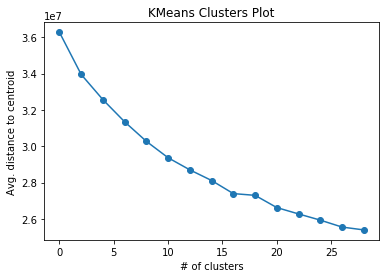

In [71]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

n=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
plt.plot(n, scores, '-o')
plt.title("KMeans Clusters Plot")
plt.ylabel('Avg. distance to centroid')
plt.xlabel('# of clusters')
plt.savefig('distance_to_centroid.png')

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 8)
gen_pred = kmeans.fit_predict(new_pca_data)
score = np.abs(kmeans.score(new_pca_data))

print("Average within-cluster distance = {}".format(score))


Average within-cluster distance = 29368809.435294095


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

After performing Principal Component Analyses on the scaled dataset I performed a random KMeans Clustering ranging from 3 to 18 components to determing the number of clusters for appropriately fitting the general population data.

Looking at the KMeans cluster plot, I decided to choose my number of clusters as 8 since, that represents the "elbow" of the curve.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [73]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter =';')

In [74]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

processed_customer_data = clean_data(customers)


In [75]:
processed_customer_data.isnull().sum().sum()


101169

In [80]:
imputed_customed_data = imputer.transform(processed_customer_data)

In [81]:
scaled_customer_data = scaler.transform(imputed_customed_data)

In [82]:
#scaled_customer_data_no_nan = pd.DataFrame(imputer.fit_transform(processed_customer_data),
#                                 columns = processed_customer_data.columns)

In [83]:
#scaled_customer_data_no_nan

In [79]:

#scaled_customer_data = pd.DataFrame(scaler.fit_transform(scaled_customer_data_no_nan),
#                                    columns = scaled_customer_data_no_nan.columns)

In [85]:

scaled_customer_data.shape


(132432, 65)

In [91]:
customer_pca = pca_28.transform(scaled_customer_data)


In [92]:
customer_pca.shape

(132432, 28)

In [93]:
clusters = kmeans.predict(customer_pca)

In [94]:
clusters

array([7, 5, 4, ..., 3, 5, 1], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

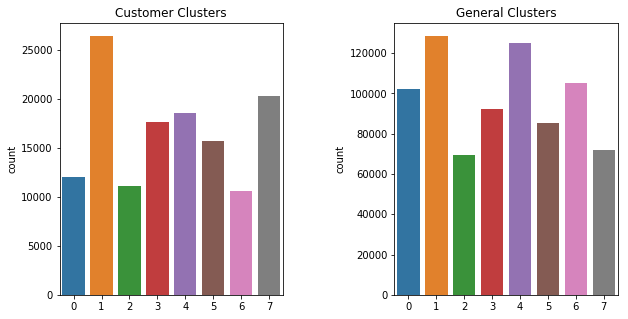

In [95]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.5)

sns.countplot(clusters, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(gen_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [96]:
cluster_7 = scaler.inverse_transform(pca_28.inverse_transform(kmeans.cluster_centers_[7]))

In [98]:
overrepresented_customer = pd.Series(data = cluster_7, index = processed_customer_data.columns)

In [99]:
overrepresented_customer

ALTERSKATEGORIE_GROB        4.189777
ANREDE_KZ                   0.750407
FINANZ_MINIMALIST           5.232524
FINANZ_SPARER               0.496698
FINANZ_VORSORGER            5.443321
FINANZ_ANLEGER              0.329540
FINANZ_UNAUFFAELLIGER       1.160300
FINANZ_HAUSBAUER            2.650320
GEBURTSJAHR              1936.322016
GREEN_AVANTGARDE            0.803993
HEALTH_TYP                  1.417257
RETOURTYP_BK_S              4.850599
SEMIO_SOZ                   5.331521
SEMIO_FAM                   4.894151
SEMIO_REL                   3.425469
SEMIO_MAT                   4.325377
SEMIO_VERT                  7.368345
SEMIO_LUST                  6.882678
SEMIO_ERL                   3.715311
SEMIO_KULT                  5.137373
SEMIO_RAT                   1.468282
SEMIO_KRIT                  2.096322
SEMIO_DOM                   2.136400
SEMIO_KAEM                  1.167113
SEMIO_PFLICHT               1.756504
SEMIO_TRADV                 2.286179
SOHO_KZ                     0.000347
A

In [4]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
'''Observing the cluster plots for both Customer data and the general population data, we can see that "Cluster: 7" seems to be overrepresented in the Customer dataset compared to the General polpulation data.'''

'Observing the cluster plots for both Customer data and the general population data, we can see that "Cluster: 7" seems to be overrepresented in the Customer dataset compared to the General polpulation data.'

In [101]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_4 = scaler.inverse_transform(pca_28.inverse_transform(kmeans.cluster_centers_[4]))

In [102]:
under_represented_customer = pd.Series(data = cluster_4, index = processed_customer_data.columns)

In [103]:
under_represented_customer

ALTERSKATEGORIE_GROB        3.270121
ANREDE_KZ                   1.433817
FINANZ_MINIMALIST           4.808743
FINANZ_SPARER               1.710630
FINANZ_VORSORGER            4.214808
FINANZ_ANLEGER              2.291493
FINANZ_UNAUFFAELLIGER       2.194900
FINANZ_HAUSBAUER            1.622195
GEBURTSJAHR              1954.900579
GREEN_AVANTGARDE            0.511994
HEALTH_TYP                  2.189298
RETOURTYP_BK_S              3.161135
SEMIO_SOZ                   4.363214
SEMIO_FAM                   3.570147
SEMIO_REL                   3.283220
SEMIO_MAT                   2.920307
SEMIO_VERT                  4.835159
SEMIO_LUST                  4.839004
SEMIO_ERL                   5.090783
SEMIO_KULT                  3.800888
SEMIO_RAT                   3.390539
SEMIO_KRIT                  4.152561
SEMIO_DOM                   4.285776
SEMIO_KAEM                  3.988640
SEMIO_PFLICHT               3.425896
SEMIO_TRADV                 3.216673
SOHO_KZ                     0.005168
A

In [5]:
"Observing the cluster plots for both Customer data and the general population data, we can see that Cluster: 4 seems to be overrepresented in the Customer dataset compared to the General polpulation data."

'Observing the cluster plots for both Customer data and the general population data, we can see that Cluster: 4 seems to be overrepresented in the Customer dataset compared to the General polpulation data.'

In [106]:
cluster_specs = pd.DataFrame(scaler.inverse_transform(pca_28.inverse_transform(kmeans.cluster_centers_)),
                             columns=processed_customer_data.columns)


cluster_specs

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.943386,1.184978,3.545205,2.112799,3.956884,1.874202,2.383272,2.976582,1958.416982,0.436373,...,1.057657,3.866053,3.099717,3.214148,6.774686,3.577514,3.861730,0.560717,3.447099,2.807569
1,3.233689,0.784821,5.127689,1.562601,4.407171,1.507647,2.072390,1.493189,1953.508936,0.746121,...,0.276537,3.586477,3.955978,2.451756,4.435698,2.421847,3.326354,0.254242,1.828378,3.472437
2,3.849993,1.142456,3.609377,0.994438,5.009714,0.696369,1.412601,4.237720,1939.736725,0.473401,...,1.255290,3.897618,2.856163,3.939217,7.898646,4.361154,1.656171,0.523104,3.801813,3.352894
3,4.287032,1.538204,4.983176,0.436504,5.535118,0.935809,1.017167,2.840693,1937.362344,0.609556,...,0.175171,3.369258,3.885851,2.450984,3.994341,2.397733,1.471402,0.389461,1.943809,3.895988
4,3.270121,1.433817,4.808743,1.710630,4.214808,2.291493,2.194900,1.622195,1954.900579,0.511994,...,-0.062670,3.430634,4.290127,2.072630,2.898020,1.773135,3.569854,0.488128,1.553006,3.558908
5,3.960262,1.908993,3.402934,0.833186,5.211506,1.249276,1.094699,4.490407,1940.053870,0.222319,...,0.946023,3.621627,3.038478,3.152109,5.880019,3.369439,1.807211,0.773344,3.669765,3.039958
6,2.886363,1.871627,3.184738,2.377395,3.647420,2.815306,2.522153,3.031755,1962.492359,0.253428,...,0.649977,3.698534,3.515412,2.905766,5.166971,3.008118,4.410298,0.743358,3.158274,2.926185
7,4.189777,0.750407,5.232524,0.496698,5.443321,0.329540,1.160300,2.650320,1936.322016,0.803993,...,0.461243,3.741394,3.829078,3.156982,5.642538,3.280280,1.253213,0.195780,2.134992,4.109596


In [3]:
'''On expading the details of our clusters using inverse_transform(), we can view the individual weights of all 8 clusters of customer data. 
 It can be observed, that cluster number 7 is the most over-represented in customer dataset compared to the general polpulation dataset. 
 Cluster 7 represents, people who are more than 60 years old; not at all finance minimalist; average uneployment; live in average size of 
 community (20K to 50K); belong to prosperous households, etc. People showing these traits should be targeted by the Mail-order company as 
 their potential new clients. '''

'On expading the details of our clusters using inverse_transform(), we can view the individual weights of all 8 clusters of customer data. \n It can be observed, that cluster number 7 is the most over-represented in customer dataset compared to the general polpulation dataset. \n Cluster 7 represents, people who are more than 60 years old; not at all finance minimalist; average uneployment; live in average size of \n community (20K to 50K); belong to prosperous households, etc. People showing these traits should be targeted by the Mail-order company as \n their potential new clients. '

### Discussion 3.3: Compare Customer Data to Demographics Data

After fitting the customer data into clusters and comparing the results with the trends of the general population, I have come to the following conclusions

OVER-REPRESENTED [Cluster no. 7]

- people who are wealthy (WEALTH = 2.13)

- People who are not financially minimalist (FINANZ_MINIMALIST ~ 5.23)

- in late years of their lives possibly the ones with families With School Age Children or Older Families & Mature   Couples, Elders with retirement, etc. (LIFE_STAGE = 4.10)

- People who are 60 years or older (ALTERSKATEGORIE_GROB = 4.109)

- conservative low returner (RETOURTYP_BK_S ~ 4.8)

- who are less socially minded (SEMIO_SOZ = 4.36)

etc. people with these abovementioned charactersitics are more prone to being popular customers of the Mail-order company.

On the other hand, UNDER-REPRESENTED [Cluster no. 4]

- People in areas where the share of 6-10 family homes is higher (PLZ8_ANTG3 ~ 3.3)

- People who are middle age, 40 to 60 years old (ALTERSKATEGORIE_GROB ~ 3)

- People who are average financial minimalist (FINANZ_MINIMALIST ~ 4.8)

- People who have average social affinity, high familiar affinity, religious affinity, etc. (SEMIO_SOZ ~ 4,3,3 respectively)

etc. are compartively less likely to be potential customers with the mail order company.




> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.